In [2]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.8 MB/s eta 0:00:00


In [3]:
import rdkit
from rdkit import Chem

print(rdkit.__version__)

2022.09.5


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from rdkit.Chem import Descriptors

In [5]:
df = pd.read_csv('Processed_Molecular_Data.csv')

In [8]:
# Feature Extraction
def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = [Descriptors.MolWt(mol), Descriptors.MolLogP(mol)]
    return descriptors

In [9]:
X = np.array([extract_descriptors(sm) for sm in df['Smiles']])
y = df['Ligand Efficiency BEI']

In [10]:
# Normalize the features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Define the VAE model
latent_dim = 2

In [11]:
# Encoder
encoder_inputs = layers.Input(shape=(X.shape[1],))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

In [14]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(X.shape[1], activation='linear')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

In [15]:
# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

In [16]:
# VAE loss
reconstruction_loss = K.mean(K.square(encoder_inputs - outputs), axis=-1)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [26]:
# Train the VAE
vae.fit(X, X, epochs=500, batch_size=16)

Epoch 1/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9252
Epoch 2/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9170
Epoch 3/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9256
Epoch 4/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9154
Epoch 5/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9036
Epoch 6/500
222/222 [==============================] - 1s 5ms/step - loss: 0.8874
Epoch 7/500
222/222 [==============================] - 1s 5ms/step - loss: 0.8963
Epoch 8/500
222/222 [==============================] - 1s 6ms/step - loss: 0.9164
Epoch 9/500
222/222 [==============================] - 1s 5ms/step - loss: 0.9076
Epoch 10/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9231
Epoch 11/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9228
Epoch 12/500
222/222 [==============================] - 1s 3ms/step - loss: 0.9088
Epoch 13/500


In [27]:
# Generate new features
n_to_generate = 10
random_latent_vectors = np.random.normal(size=(n_to_generate, latent_dim))
generated_features = decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 21ms/step


In [28]:
# Denormalize the generated features
generated_features = generated_features * X_std + X_mean

In [29]:
print("Generated Features:")
print(generated_features)

Generated Features:
[[371.45965946   3.1603274 ]
 [402.37959007   3.83923633]
 [419.82601996   4.13829981]
 [424.23278349   4.18745241]
 [418.28353416   4.11902038]
 [446.03559331   4.38053406]
 [397.44089133   3.73092355]
 [407.19885119   3.94186452]
 [404.85920541   3.89350978]
 [377.87883117   3.30113904]]


In [33]:
# Convert features to SMILES
def features_to_smiles(original_smiles, features):
    # Convert original SMILES to a molecule
    mol = Chem.MolFromSmiles(original_smiles)

    # Modify the molecule based on the generated features
    mol.SetProp('MolWt', str(features[0]))
    mol.SetProp('MolLogP', str(features[1]))

    # Convert the modified molecule to SMILES
    smiles = Chem.MolToSmiles(mol)
    return smiles

In [34]:
# Convert generated features to SMILES strings
generated_smiles = [features_to_smiles(smiles, features) for smiles, features in zip(df['Smiles'], generated_features)]

In [35]:
# Display generated SMILES
for sm in generated_smiles:
    print(sm)

O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2)C1CF
O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n2-c2ccccc2)C1
C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl
C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl
C[C@H]1c2ncnc(-c3ccn[nH]3)c2CCN1C(=O)c1ccc(F)c(C(F)(F)F)c1Cl
C[C@H]1Cn2c(nnc2-c2cnccn2)C(=O)N1Cc1cccc(Cl)c1Cl
C[C@H]1Cn2c(nnc2C2CCC2)C(=O)N1Cc1cccc(C(F)(F)F)c1Cl
Cc1nc2c(c(-c3ccn[nH]3)n1)CC(C)N(C(=O)c1cccc(C)c1C)C2
Cc1nc2c(c(-c3ccn[nH]3)n1)C[C@H](C)N(C(=O)c1ccc(Cl)c(F)c1Cl)C2
CC1CN(C(=O)c2cccc(Cl)c2Cl)Cc2nnc(-c3ccc(F)cc3)n21


In [43]:
# Define a neural network model
def create_model(input_shape):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error loss for regression
    return model

In [44]:
# Feature extraction
X_train = np.array([extract_descriptors(sm) for sm in df['Smiles']])
y_train = df['Ligand Efficiency BEI']

In [45]:
# Normalize features
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

In [46]:
# Create and train the neural network model
input_shape = X_train.shape[1:]
nn_model = create_model(input_shape)
nn_model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50
222/222 [==============================] - 1s 2ms/step - loss: 98.4263
Epoch 2/50
222/222 [==============================] - 0s 2ms/step - loss: 8.4751
Epoch 3/50
222/222 [==============================] - 1s 5ms/step - loss: 6.9077
Epoch 4/50
222/222 [==============================] - 1s 6ms/step - loss: 6.6768
Epoch 5/50
222/222 [==============================] - 1s 5ms/step - loss: 6.6093
Epoch 6/50
222/222 [==============================] - 1s 3ms/step - loss: 6.5947
Epoch 7/50
222/222 [==============================] - 1s 3ms/step - loss: 6.5807
Epoch 8/50
222/222 [==============================] - 1s 3ms/step - loss: 6.5631
Epoch 9/50
222/222 [==============================] - 1s 3ms/step - loss: 6.4944
Epoch 10/50
222/222 [==============================] - 1s 2ms/step - loss: 6.5026
Epoch 11/50
222/222 [==============================] - 0s 2ms/step - loss: 6.4834
Epoch 12/50
222/222 [==============================] - 0s 2ms/step - loss: 6.4898
Epoch 13/50
222/222 [===

In [47]:
# Convert features of generated SMILES to match the model input
X_generated = np.array([extract_descriptors(sm) for sm in generated_smiles])
X_generated = (X_generated - X_train.mean(axis=0)) / X_train.std(axis=0)

In [48]:
# Predict ligand efficiency for generated SMILES using the neural network model
predicted_ligand_efficiency_nn = nn_model.predict(X_generated).flatten()

1/1 [==============================] - 0s 92ms/step


In [49]:
# Display predicted ligand efficiency for generated SMILES
for sm, le in zip(generated_smiles, predicted_ligand_efficiency_nn):
    print(f"SMILES: {sm}, Predicted Ligand Efficiency (Neural Network): {le}")

SMILES: O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2)C1CF, Predicted Ligand Efficiency (Neural Network): 53.3857421875
SMILES: O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n2-c2ccccc2)C1, Predicted Ligand Efficiency (Neural Network): 56.54859924316406
SMILES: C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl, Predicted Ligand Efficiency (Neural Network): 53.29331970214844
SMILES: C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl, Predicted Ligand Efficiency (Neural Network): 52.89372253417969
SMILES: C[C@H]1c2ncnc(-c3ccn[nH]3)c2CCN1C(=O)c1ccc(F)c(C(F)(F)F)c1Cl, Predicted Ligand Efficiency (Neural Network): 53.59312438964844
SMILES: C[C@H]1Cn2c(nnc2-c2cnccn2)C(=O)N1Cc1cccc(Cl)c1Cl, Predicted Ligand Efficiency (Neural Network): 48.90184020996094
SMILES: C[C@H]1Cn2c(nnc2C2CCC2)C(=O)N1Cc1cccc(C(F)(F)F)c1Cl, Predicted Ligand Efficiency (Neural Network): 49.34141540527344
SMILES: Cc1nc2c(c(-c3ccn[nH]3)n1)CC(C)N(C(=O)c1cccc(C)c1C)C2, Predicted Ligand Efficiency (Neural Netwo

In [50]:
highest_bei_value = df['Ligand Efficiency BEI'].max()
print("Highest BEI value:", highest_bei_value)

Highest BEI value: 37.9


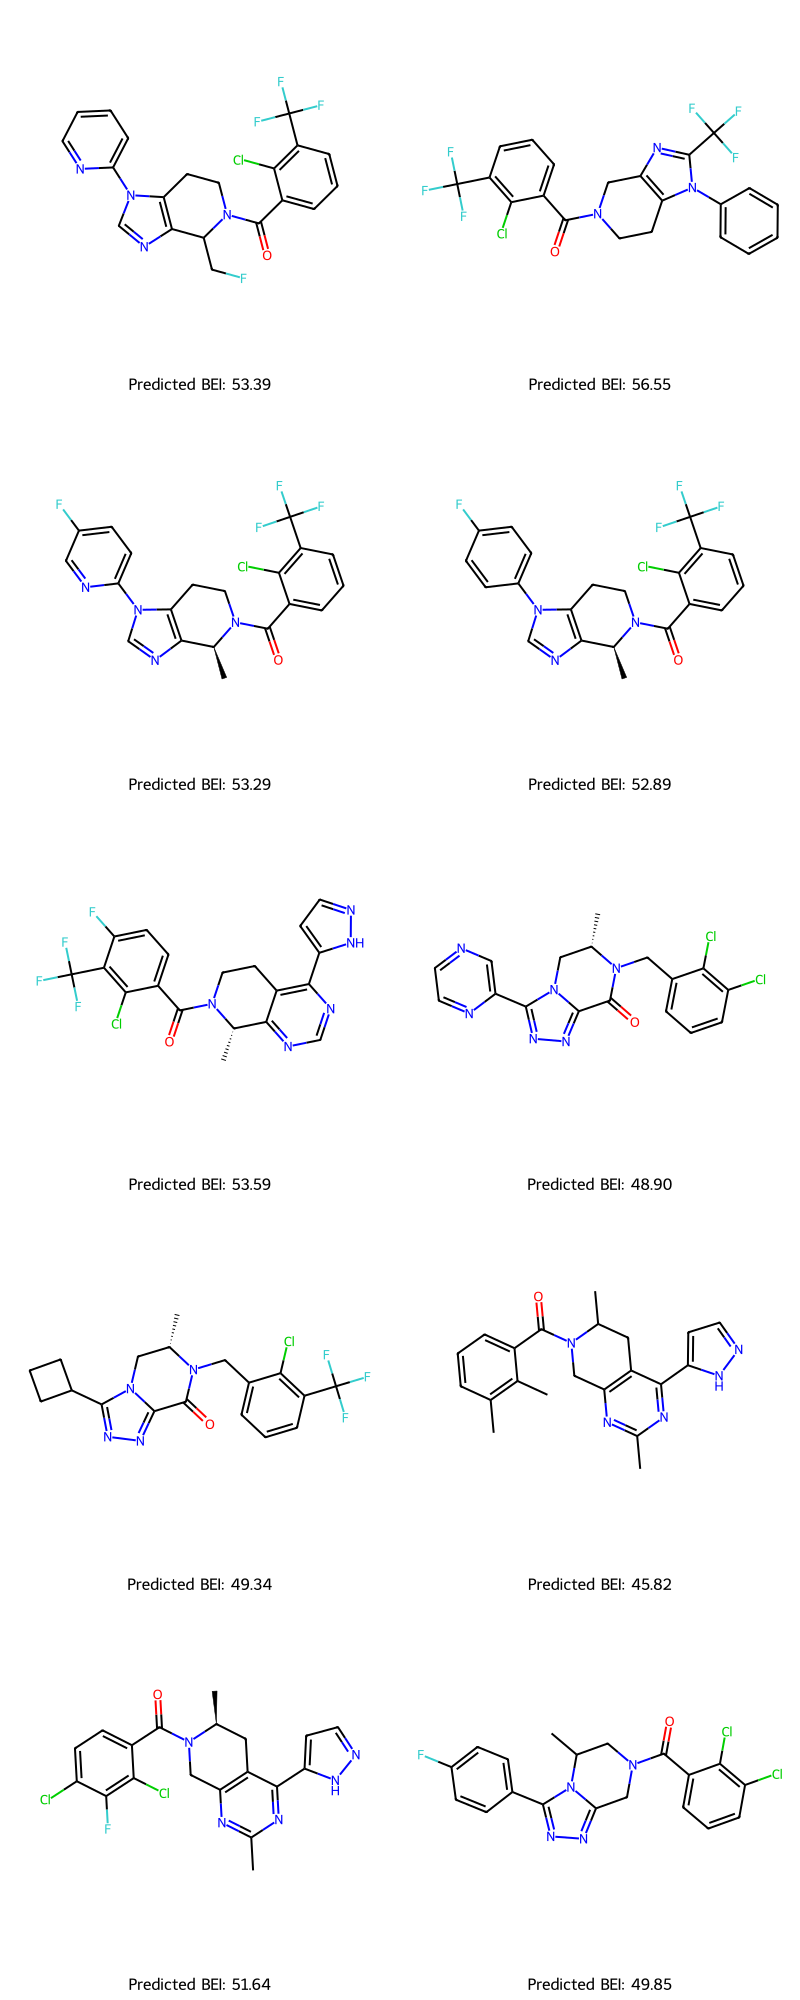

In [52]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# SMILES strings
smiles_list = [
    "O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2)C1CF",
    "O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n2-c2ccccc2)C1",
    "C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl",
    "C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(F)(F)F)c1Cl",
    "C[C@H]1c2ncnc(-c3ccn[nH]3)c2CCN1C(=O)c1ccc(F)c(C(F)(F)F)c1Cl",
    "C[C@H]1Cn2c(nnc2-c2cnccn2)C(=O)N1Cc1cccc(Cl)c1Cl",
    "C[C@H]1Cn2c(nnc2C2CCC2)C(=O)N1Cc1cccc(C(F)(F)F)c1Cl",
    "Cc1nc2c(c(-c3ccn[nH]3)n1)CC(C)N(C(=O)c1cccc(C)c1C)C2",
    "Cc1nc2c(c(-c3ccn[nH]3)n1)C[C@H](C)N(C(=O)c1ccc(Cl)c(F)c1Cl)C2",
    "CC1CN(C(=O)c2cccc(Cl)c2Cl)Cc2nnc(-c3ccc(F)cc3)n21"
]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Visualize molecules
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=[f"Predicted BEI: {bei:.2f}" for bei in predicted_ligand_efficiency_nn])
display(img)